In [69]:
import pandas as pd
import os
import sys

# Make project src directory importable
project_root = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(project_root, "src"))

from spend_model.data_load import load_raw_data
from spend_model.features import engineer_features
from spend_model.features import TARGET_COL
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

In [56]:
# load raw car price data

df = load_raw_data()
print(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns.")
df.head(5)

Loaded dataset with 205 rows and 26 columns.


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [57]:
# apply feature engineering to add derived features

df_eng = engineer_features(df)
print(f"Engineered dataset has {len(df_eng)} rows and {len(df_eng.columns)} columns.")

print("New columns added:", set(df_eng.columns) - set(df.columns))
# set is used here to make a unique dict of columns from the original
# df and minus the unique columns from the engineered dataframes

Engineered dataset has 205 rows and 31 columns.
New columns added: {'mpg_combined', 'car_brand', 'power_weight_ratio', 'engine_efficiency', 'car_model'}


In [58]:
# select the relevant features for clustering analysis

features = ["power_weight_ratio", "mpg_combined", "engine_efficiency"]

x_clust = df_eng[features].copy()

print(f"head: \n {x_clust.head(5)}")
print("\n")
print(f"describe: \n {x_clust.describe()}")

head: 
    power_weight_ratio  mpg_combined  engine_efficiency
0            0.043564          24.0           0.853846
1            0.043564          24.0           0.853846
2            0.054552          22.5           1.013158
3            0.043646          27.0           0.935780
4            0.040722          20.0           0.845588


describe: 
        power_weight_ratio  mpg_combined  engine_efficiency
count          205.000000    205.000000         205.000000
mean             0.040063     27.985366           0.822331
std              0.009570      6.666038           0.182925
min              0.019936     15.000000           0.509091
25%              0.034188     22.500000           0.711340
50%              0.037801     27.000000           0.779817
75%              0.044489     32.000000           0.883978
max              0.085561     51.500000           1.687500


In [59]:
# The three features are on different scales (e.g. power_weight_ratio is typically a small number
# around 0.05, mpg_combined is tens of MPG, etc.), so we standardize them. We use StandardScaler
# to normalize each feature to zero mean and unit variance:

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_clust)

In [60]:
inertias = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans_k = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans_k.fit_predict(x_scaled)
    
    inertias.append(kmeans_k.inertia_)
    silhouette_avg = silhouette_score(x_scaled, labels)
    silhouette_scores.append(silhouette_score(x_scaled, labels))

print("Inertia (SSE):", inertias)
print("Silhouette scores:", silhouette_scores)

Inertia (SSE): [321.75853668415084, 225.34479293669364, 181.72353891838208, 154.8682993806913, 127.84093821256126, 113.34027887911996, 97.92132377514768, 87.44541206363621, 77.60115485750151]
Silhouette scores: [0.4389696855768071, 0.3632460465705291, 0.3272963206400094, 0.3388221034917841, 0.35284841546691875, 0.3292398996994054, 0.3483126082233833, 0.37745297159498353, 0.39025287062335595]


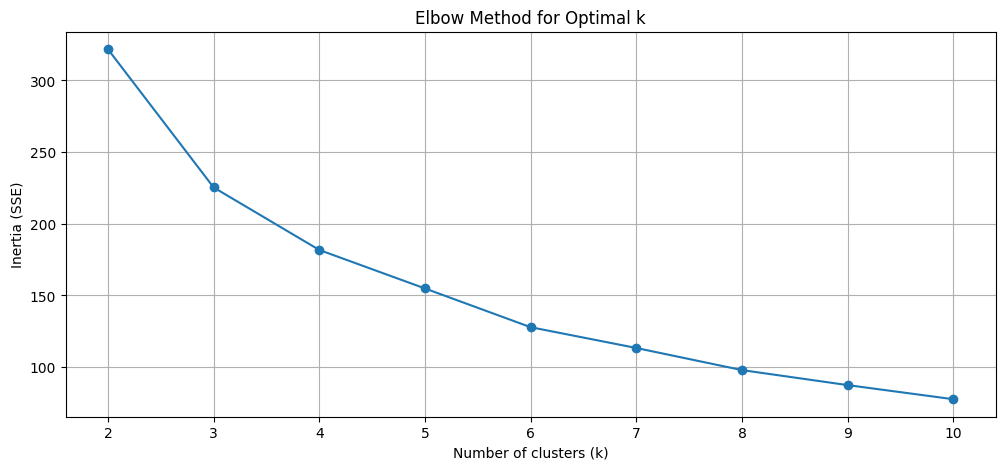

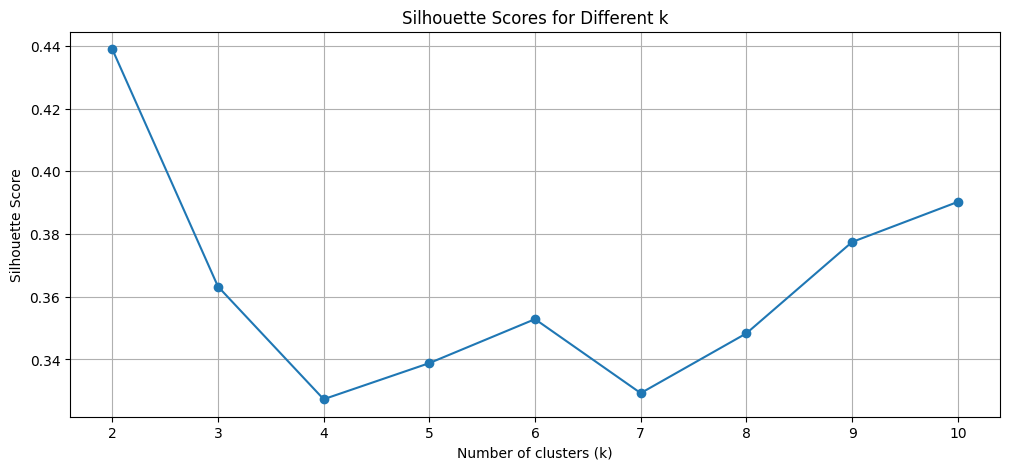

In [61]:
plt.figure(figsize=(12, 5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.xticks(k_values)
plt.grid()
plt.show()

In [62]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(x_scaled)

In [63]:
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids, columns=features)
centroid_df.index.name = "Cluster"
centroid_df

,power_weight_ratio,mpg_combined,engine_efficiency
Cluster,,,
0,0.032408,35.918033,0.698390
1,0.038455,25.906250,0.775626
2,0.053008,22.062500,1.073249


In [64]:
unique, counts = np.unique(cluster_labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

Cluster sizes: {np.int32(0): np.int64(61), np.int32(1): np.int64(96), np.int32(2): np.int64(48)}


In [70]:
# (Optional) Analyze average price per cluster
df_eng['Cluster'] = cluster_labels
avg_price_per_cluster = df_eng.groupby('Cluster')[TARGET_COL].mean()
avg_price_per_cluster

Cluster
0     7920.754098
1    14395.593750
2    17845.472229
Name: price, dtype: float64

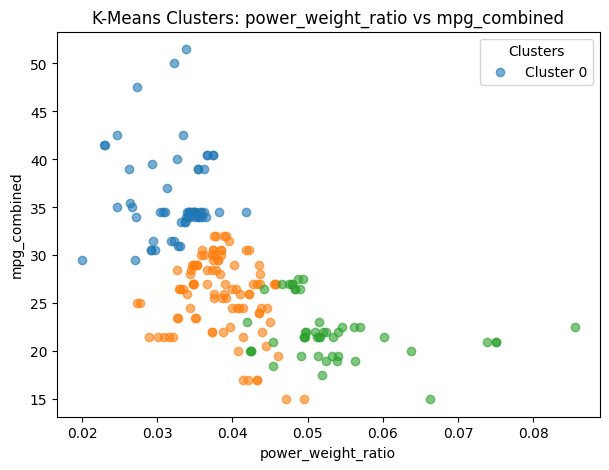

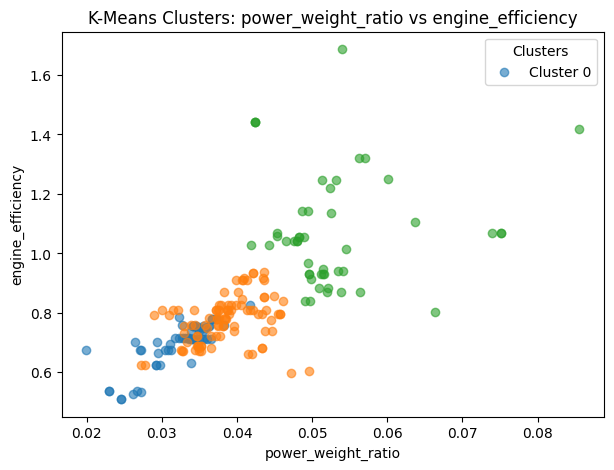

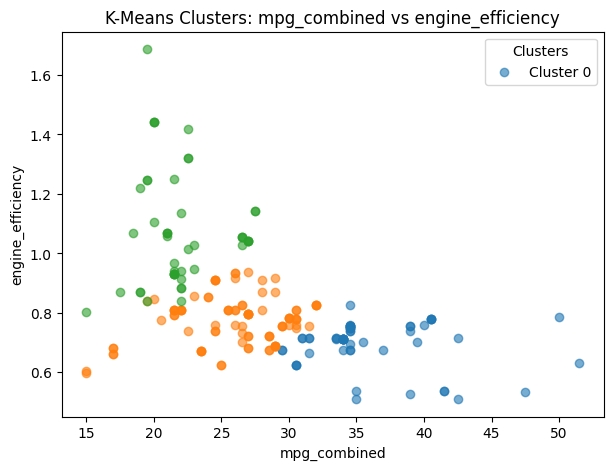

In [66]:
for x_col, y_col in combinations(features, 2):
    plt.figure(figsize=(7, 5))

    for c in range(optimal_k):
        plt.scatter(
            x_clust.loc[cluster_labels == c, x_col],
            x_clust.loc[cluster_labels == c, y_col],
            alpha=0.6,
            # avoid duplicate legend entries
            label=f"Cluster {c}" if c == 0 else None
        )

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"K-Means Clusters: {x_col} vs {y_col}")
    plt.legend(title="Clusters")
    plt.show()

In [67]:
print(features)

['power_weight_ratio', 'mpg_combined', 'engine_efficiency']
